In [1]:
import os
import gym
import matplotlib.pyplot as plt
import griddly
import itertools
import numpy as np
import seaborn as sns
import torch
import wandb
import skvideo.io

from skimage.transform import resize
from skimage.color import rgba2rgb
from models.disentangle_network import DisentangleNetwork
from ppo_ir_modules import EpisodicMemory
from utils import wrap_env

In [2]:
client = wandb.Api()

In [3]:
def make_env(env_name):
    env = wrap_env(env_name, max_frames=500, frame_stack=False, obs_shape=(84,84), test=True, punishment=1, no_ext=True)
    env.enable_history(True)
    env.seed(100)
    return env

In [4]:
PATH = "ut-rl-control/cen-rl/{}"

def load_config(run_id):
    run = client.run(PATH.format(run_id))
    config = run.config
    return config

def load_model(run_id, env, download=False):
    run_path = PATH.format(run_id)
    config = load_config(run_id)
    
    num_actions = min(10, env.action_space.n)
    image_channels = env.observation_space.shape[0]
    if config['IR_module'] == 'CTRL':
        mask_network = DisentangleNetwork(image_channels, num_actions, config['ctrl_hidden_size'], config['ctrl_channels'], config['ctrl_latent_size'], config['ctrl_encoder_out'], config.get('ctrl_action_size', 8)).to(device).eval()
        combine_masks = False
        model_name = 'disentanglement'
    else:
        raise ValueError('Model type not supported ({})'.format(config['IR_module']))

    if download:
        wandb.restore('{}_{}_network.pth'.format(model_name, run_id), run_path=run_path, replace=True)
        
    mask_network.load_state_dict(torch.load('{}_{}_network.pth'.format(model_name, run_id), map_location=device), strict=True)
    # mask_network = torch.load('{}_{}_network.pth'.format(model_name, run_id), map_location=device)

    return mask_network, combine_masks

In [5]:
cen_run_id = '41mn1pc9'
config = load_config(cen_run_id)

device = torch.device('cpu')
env = make_env(config['env_name'])

cen_network, cen_combine_masks = load_model(cen_run_id, env)
config['combine_masks'] = cen_combine_masks

[2021-11-29 21:27:36.226] [info] Loading GDY file: /home/ocorcoll/projects/controllable-IR/gdy_envs/zelda_mod.yml
[2021-11-29 21:27:36.229] [info] Loading GDY file Version: 0.1.
[2021-11-29 21:27:36.229] [info] Loading 7 objects...
[2021-11-29 21:27:36.229] [info] Loading 5 actions...
[2021-11-29 21:27:36.229] [info] Loading Environment...
[2021-11-29 21:27:36.229] [info] Loaded 3 levels
CNNDecoder(
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padd

In [6]:
config['ngu_k_neighbors'] = 2
config['ir_eps'] = 1.0
# config['ir_c'] = 0.001
# config['ir_max_sim'] = 1.5
# config['ir_psi'] = 0.4
episodic_memory = EpisodicMemory(config['ngu_mem'], config['ctrl_latent_size'], config['ngu_k_neighbors'], config['ir_eps'], config['ir_c'], config['ir_psi'], config['ir_max_sim'])

In [7]:
print(config['ngu_k_neighbors'], config['ir_eps'], config['ir_c'], config['ir_psi'], config['ir_max_sim'])

2 1.0 0.001 0.8 2


In [8]:
def to_video(frames, output_file='eval_video.mp4'):
    fps = '12'
    writer = skvideo.io.FFmpegWriter(output_file, 
        inputdict={'-r': fps},
        outputdict={'-r': fps},
    )

    for frame in frames:
        writer.writeFrame(frame)
    writer.close()

def mask_observation(observation, mask, threshold=0.03, use_negative=True):
    if use_negative:
        mask = np.abs(mask)

    binary_mask = (mask >= threshold).astype(float) + 0.7
    binary_mask = resize(binary_mask, observation.shape)
    
    image = observation * binary_mask
    # image = np.concatenate([observation / 255., binary_mask], axis=-1)
    # image = rgba2rgb(image)
    # image = np.clip(image * 255, 0, 255).astype(np.uint8)
    image = np.clip(image, 0, 255).astype(np.uint8)

    return image

In [9]:
def score(episodic_memory, embedding):
    if episodic_memory.num < 30:
        return 0, -1

    test = np.array(embedding).ravel()[None, :]
    dists = np.sum((test - episodic_memory.memory[:episodic_memory.num])**2, axis=1)
    k_dist = np.partition(dists, episodic_memory.k_neighbors+1)[:episodic_memory.k_neighbors+1] if len(dists) > episodic_memory.k_neighbors+1 else np.sort(dists)[:episodic_memory.k_neighbors+1]
    k_dist = np.delete(k_dist, k_dist.argmin()) if len(k_dist) > 1 else k_dist
    
    episodic_memory.running_sum += np.sum(k_dist)
    episodic_memory.running_num += len(k_dist)
    running_mean = episodic_memory.running_sum / episodic_memory.running_num
    
    dist_normalized = k_dist / max(running_mean, 1e-8)   # (running_mean if abs(running_mean - 0)>self.psi else self.psi )
    dist_normalized = np.maximum(dist_normalized - episodic_memory.psi, 0)
    dist_kernel = episodic_memory.eps / (episodic_memory.eps + dist_normalized)
    
    sim = np.sqrt(np.sum(dist_kernel)) + episodic_memory.C
    score = 0 if sim >= episodic_memory.max_sim else 1 / sim
    print(score, sim, dist_kernel, dist_normalized, k_dist)
    return score, dist_normalized

In [21]:
def process_obs(obs):
    if obs is None:
        observation_raw = env.reset()
    else:
        observation_raw = obs

    if config['env_name'].startswith('GDY'):
        observation = torch.from_numpy(observation_raw).to(device) / 255.
        observation_raw = np.transpose(observation_raw, (1, 2, 0))
    else:
        observation = torch.from_numpy(np.asarray(observation_raw)).to(device) / 255.
        observation_raw = env.raw_last_obs

    return observation, observation_raw

episodic_memory.reset()
num_actions = min(10, env.action_space.n)
output_channels = env.observation_space.shape[0]
state = env.get_state()
observation, observation_raw = process_obs(None)

total_steps = 0
step = 0
episode = list()
episode_index = 0
data = list()
while len(data) < 100:
    action = torch.randint(num_actions, (1,)).to(device)

    next_observation, _, done, info = env.step(action.item())
    next_observation, next_observation_raw = process_obs(next_observation)
    total_effect = next_observation[-output_channels:] - observation[-output_channels:]
    step += 1
    total_steps += 1

    with torch.no_grad():
        cen_controlled_mask, cen_normal_mask, controlled_embedding, _ = cen_network(observation.unsqueeze(0), action)

    cen_controlled_mask_raw = cen_controlled_mask
    cen_normal_mask_raw = cen_normal_mask
    controlled_embedding = controlled_embedding.cpu().detach().numpy()
    episodic_memory.add_item(controlled_embedding.squeeze(0))
    reward, distance = score(episodic_memory, controlled_embedding)
    events = [f"{event['SourceObjectName']}-{event['ActionName']}-{event['DestinationObjectName']}" for event in info[0]['History'] if f"{event['SourceObjectName']}-{event['ActionName']}-{event['DestinationObjectName']}" not in ('key-pick_key-key', 'spider-random_movement-_empty', 'attack_fire-remove_sprite-attack_fire')]
    print(step, episodic_memory.num, done, reward, distance, cen_controlled_mask.abs().sum(), events)

    episode.append(mask_observation(next_observation_raw, cen_controlled_mask_raw.permute(0, 2, 3, 1).squeeze().cpu().numpy()))

    if 'ale.lives' in info:
        done = ('needs_reset' in info and info['needs_reset']) or info['ale.lives'] == 0
    
    if done or len(episode) >= 500:
        next_observation, next_observation_raw = process_obs(None)
        episode = list()
        step = 0
        episodic_memory.reset()

    if not done:
        # if 'avatar-move-near_key' in events:# or reward >= 0.7:
        if reward >= 0.5:
            data.append((observation_raw, next_observation_raw, cen_controlled_mask_raw, cen_normal_mask_raw, total_effect, cen_controlled_mask, reward, step, events))
        
    observation = next_observation
    observation_raw = next_observation_raw
    state = env.get_state()
    
print(total_steps)

1 1 False 0 -1 tensor(14.4756) []
2 2 False 0 -1 tensor(14.3425) []
3 3 False 0 -1 tensor(34.2762) ['avatar-move-_empty']
4 4 False 0 -1 tensor(0.3744) []
5 5 False 0 -1 tensor(0.3744) ['spider-random_movement-spider']
6 6 False 0 -1 tensor(0.3744) []
7 7 False 0 -1 tensor(27.8820) ['avatar-move-avatar']
8 8 False 0 -1 tensor(32.7162) ['avatar-attack-_empty']
9 9 False 0 -1 tensor(28.8911) ['avatar-move-_empty']
10 10 False 0 -1 tensor(56.5137) ['avatar-move-_empty']
11 11 False 0 -1 tensor(47.8261) ['avatar-move-_empty']
12 12 False 0 -1 tensor(34.4331) ['avatar-move-avatar']
13 13 False 0 -1 tensor(0.3744) []
14 14 False 0 -1 tensor(0.3744) []
15 15 False 0 -1 tensor(0.3744) ['avatar-attack-wall']
16 16 False 0 -1 tensor(28.5967) ['avatar-move-avatar']
17 17 False 0 -1 tensor(34.5294) ['avatar-move-avatar']
18 18 False 0 -1 tensor(0.3744) []
19 19 False 0 -1 tensor(22.5848) ['avatar-move-avatar']
20 20 False 0 -1 tensor(28.0933) ['avatar-move-avatar']
21 21 False 0 -1 tensor(0.3744) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


66 100 96 0.7066071344901148 []


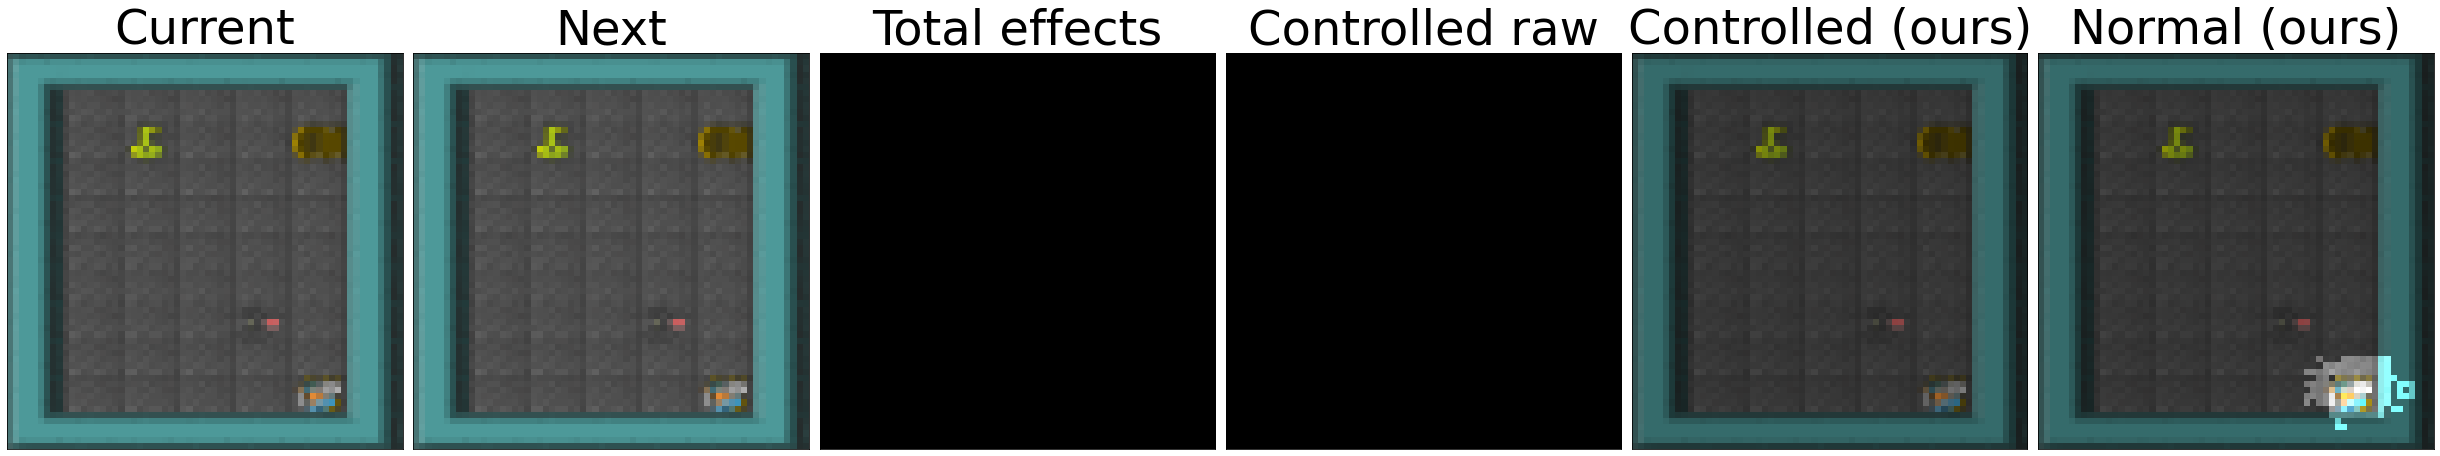

In [22]:
fig, axes = plt.subplots(figsize=(34, 24), ncols=6, nrows=1)

index = np.random.randint(len(data))
item = data[index]
observation = item[0]
next_observation = item[1]
cen_controlled_mask = item[2].squeeze().permute(1, 2, 0).cpu().numpy()
cen_normal_mask = item[3].squeeze().cpu().numpy().squeeze()
total_effect = item[4].permute(1, 2, 0).cpu().numpy().squeeze()
threshold_cen_controlled_mask = item[5].cpu().numpy().squeeze()
reward = item[6]
step = item[7]
events = item[8]
print(index, len(data), step, reward, events)

for ax in axes.flat:
    ax.tick_params(axis="both", which = "both", bottom = False, top = False, left=False,right=False, labelleft=False,labelbottom=False)
    ax.imshow(np.zeros_like(observation))

axes[0].imshow(observation)
axes[1].imshow(next_observation)
axes[2].imshow(total_effect)
axes[3].imshow(cen_controlled_mask)
axes[4].imshow(mask_observation(observation, threshold_cen_controlled_mask))
axes[5].imshow(mask_observation(observation, (np.abs(cen_normal_mask) > 0.01).max(axis=0)[None].transpose(1, 2, 0)))


axes[0].xaxis.set_label_position('top')
axes[1].xaxis.set_label_position('top')
axes[2].xaxis.set_label_position('top')
axes[3].xaxis.set_label_position('top')
axes[4].xaxis.set_label_position('top')
axes[5].xaxis.set_label_position('top')

axes[0].set_xlabel('Current', color='black', fontsize=48., labelpad=10.)
axes[1].set_xlabel('Next', color='black', fontsize=48., labelpad=10.)
axes[2].set_xlabel('Total effects', color='black', fontsize=48., labelpad=10.)
axes[3].set_xlabel('Controlled raw', color='black', fontsize=48., labelpad=10.)
axes[4].set_xlabel('Controlled (ours)', color='black', fontsize=48., labelpad=10.)
axes[5].set_xlabel('Normal (ours)', color='black', fontsize=48., labelpad=10.)

plt.tight_layout()
plt.show()

In [12]:
print(config['ir_eps'], episodic_memory.psi, episodic_memory.running_sum, episodic_memory.running_num, episodic_memory.running_sum / episodic_memory.running_num)

# 1.0568431790885309 0.9462141780225568 [0.63629126 0.10932554 0.07266823 0.04411652 0.0310283 ] [0.05716073 0.81469932 1.27611727 2.1667247  3.12286479] [109.35976057 206.00935655 264.87877885 378.50579352 500.49370893]
# 140 140 False 1.0568431790885309 [0.05716073 0.81469932 1.27611727 2.1667247  3.12286479] tensor(3.0547) ['avatar-move-wall']

# 0.8034969712584142 1.2445597628499188 [1.         0.04580915 0.06038298 0.39450648 0.04574228] [0.         2.08297013 1.55609583 0.15348126 2.08616136] [ 51.81876945 368.09735019 300.8260899  121.74039622 368.50480649]
# 135 135 False 0.8034969712584142 [0.         2.08297013 1.55609583 0.15348126 2.08616136] tensor(70.9445) ['avatar-move-near_key']





# 1.5584735562574974 0.6416534922808635 [0.19653795 0.09678124 0.05011743 0.04955342 0.01744687] [0.04088076 0.09332581 0.18953139 0.19180244 0.56316873] [ 79.97846524  84.96665733  94.11703225  94.33303818 129.65470039]
# 77 77 False 1.5584735562574974 [0.04088076 0.09332581 0.18953139 0.19180244 0.56316873] tensor(22.4122) ['avatar-move-avatar']

# 0.975896389174159 1.0246989445736534 [0.01606399 0.00977901 1.         0.0135587  0.00855782] [0.61251021 1.01259831 0.         0.72753376 1.15852143] [134.09502293 172.07692372  69.12087979 145.01465061 185.929966  ]
# 79 79 False 0.975896389174159 [0.61251021 1.01259831 0.         0.72753376 1.15852143] tensor(59.3055) ['avatar-move-near_key']


dists = [
    [0.04088076, 0.09332581, 0.18953139, 0.19180244, 0.56316873],
    [0.61251021, 1.01259831, 0., 0.72753376, 1.15852143],
]
for i, dist in enumerate(dists):
    for eps in [1.0, 0.1, 0.01, 0.001]:
        print(i, eps, [eps / (eps + d) for d in dist], np.sqrt(np.sum(eps / (eps + np.asarray(dist)))) + episodic_memory.C, 1 / (np.sqrt(np.sum(eps / (eps + np.asarray(dist)))) + episodic_memory.C))
    print()

1.0 0.8 13060.815042505954 120 108.84012535421628
0 1.0 [0.9607248384531576, 0.9146404400715648, 0.8406671807122299, 0.8390652397053323, 0.639726205372596] 2.049126925831229 0.48801271770627375
0 0.1 [0.7098201344172193, 0.5172615079176444, 0.34538569375845574, 0.3426976141803338, 0.15079118703320044] 1.4383434305366458 0.6952442502740115
0 0.01 [0.19653794479484976, 0.09678123984704307, 0.05011742763882916, 0.049553414715897394, 0.017446869441045745] 0.6416534917080099 1.558473557648867
0 0.001 [0.023877312637115466, 0.010601552215666105, 0.0052484790039058656, 0.005186656351444515, 0.0017725193666795393] 0.21707063561440157 4.6067953740936805

1 1.0 [0.6201511120974545, 0.4968701379859551, 1.0, 0.5788598886773709, 0.46328008890789657] 1.7784029446551157 0.562302262828253
1 0.1 [0.14034886601835503, 0.08987969791181868, 1.0, 0.12084099142976355, 0.07945832118250064] 1.1970467702152945 0.835389247005065
1 0.01 [0.01606399355281257, 0.009779010880626236, 1.0, 0.013558701367107589, 0.008